# Prepare data for random forest

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
sales = pd.read_feather('./input/train_data.ftr')
test = pd.read_csv('./input/test.csv')

In [29]:
# sales.isnull().sum()

## Encode categorical values

In [30]:
def encode_categorical_columns(df, encoder, cat_cols=[], cat_cols_type='object'):
    if len(cat_cols)>0:
        cat_temp = df.loc[:, cat_cols].copy()
    else:
        cat_cols = df.dtypes[df.dtypes == 'object'].index.tolist()
        cat_temp = df.loc[:, cat_cols].copy()
    enc_cat_cols = [f'encoded_{o}' for o in cat_cols]
    cat_data_codes = encoder.fit_transform(cat_temp)
    cat_data_codes = pd.DataFrame(cat_data_codes, columns=enc_cat_cols).astype('float32')
    df.drop(columns=cat_cols, inplace=True)
    return df.join(cat_data_codes)

In [31]:
enc = OrdinalEncoder()

In [32]:
sales = encode_categorical_columns(sales, enc)

In [9]:
# sales.info()

In [82]:
features_to_drop = ['item_cnt_month - 6',
 'median_monthly_price - 1',
 'encoded_location',
 'item_cnt_month - 2',
 'item_cnt_month - 5',
 'item_cnt_month - 4',
 'delta_sq_item_cnt_month_2-4',
 'encoded_cat_code',
 'delta_item_cnt_month_2-3',
 'item_cnt_month - 3',
 'delta_sq_item_cnt_month_3-5',
 'year',
 'delta_sq_item_cnt_month_4-6',
 'delta_item_cnt_month_3-4',
 'delta_item_cnt_month_4-5',
 'delta_item_cnt_month_5-6']

In [83]:
sales.drop(columns=features_to_drop, inplace=True)

# Random Forest

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import gc

In [85]:
def create_submission(tset, testdf, preds):
    preds = np.clip(preds,0,20)
    tset['item_cnt_month'] = preds
    sub = testdf.merge(tset, 'inner', on=['shop_id', 'item_id']).loc[:,['ID', 'item_cnt_month']]
    sub.to_csv('./submission.csv', index=False)

def fi(model, df):
    f = model.feature_importances_
    cols = df.columns
    x = pd.DataFrame({'Features': cols, 'Importance': f})
    x.sort_values(by='Importance', ascending=False, ignore_index=True, inplace=True)
    return x

def train_rf_regressor(X, y, 
                       n_estimators=40, max_samples=500000,
                       min_samples_leaf=5, oob_score=True,
                       n_jobs=-1, verbose=0, max_features=0.5):
    return RandomForestRegressor(n_estimators=n_estimators, 
                                 max_samples=max_samples, 
                                 min_samples_leaf=min_samples_leaf,
                                 oob_score=oob_score, n_jobs=-1, 
                                 verbose=verbose, max_features=max_features).fit(X,y)

def validate_rf_regressor(model, train_x, train_y, valid_x, valid_y):
    # OOB Score based attributes
    if hasattr(model, 'oob_score_'):
        oob_preds = np.clip(model.oob_prediction_, 0, 20)
        rmse_oob = rmse_score(oob_preds, train_y)
        print(f'RMSE - OOB : {rmse_oob}')
        print(f'R2 - OOB {model.oob_score_}\n')
    else:
        print('OOB score is not available\n')
    
    print('#######################################\n')
    
    # Metrics on Validation set
    preds = np.clip(model.predict(valid_x),0,20)
    rmse_v = rmse_score(preds, valid_y)
    rsquared_valid = r2_score(valid_y, preds)
    print(f'RMSE - Valid: {rmse_v}')
    print(f'R2 - Valid : {rsquared_valid}\n')
    
    print('#######################################\n')
    
    # Metrics on Training set
    preds = np.clip(model.predict(train_x),0,20)
    rmse_t = rmse_score(preds, train_y)
    rsquared_t = r2_score(train_y, preds)
    print(f'RMSE - Train : {rmse_t}')
    print(f'R2- Train : {rsquared_t}\n')
    
    print('#######################################\n')    
    
    t_predictions = np.stack([t.predict(valid_set) for t in model.estimators_])
    plt.plot([rmse_score(t_predictions[:i+1].mean(0), valid_y) for i in range(len(model.estimators_))]);
    
    
def rmse_score(preds, truth_val):
    preds = np.clip(preds, 0, 20)
    truth_val = np.clip(truth_val, 0, 20)
    return np.sqrt(mean_squared_error(truth_val, preds))


## Declare training, validation and test sets

In [86]:
test_idxs = np.where(sales.date_block_num == 34)[0]
valid_idxs = np.where(sales.date_block_num == 33)[0]
train_idxs = np.where(sales.date_block_num<=32)[0]

In [87]:
test_set = sales.loc[test_idxs]
valid_set = sales.loc[valid_idxs]
train_set = sales.loc[train_idxs]

In [88]:
# valid_set

## Get Labels

In [89]:
train_y = np.clip(train_set['item_cnt_month'],0,20)
valid_y = np.clip(valid_set['item_cnt_month'],0,20)

In [90]:
train_set.drop(columns=['item_cnt_month'], inplace=True)
valid_set.drop(columns='item_cnt_month', inplace=True)
test_set.drop(columns=['item_cnt_month'], inplace=True)

### Train Random forest model

In [48]:
rfr = train_rf_regressor(train_set, train_y, n_estimators=200, min_samples_leaf=5, oob_score=False)

OOB score is not available

#######################################

RMSE - Valid: 0.5814249571398162
R2 - Valid : 0.32643636669291454

#######################################

RMSE - Train : 0.5967103550081267
R2- Train : 0.493486905083219

#######################################



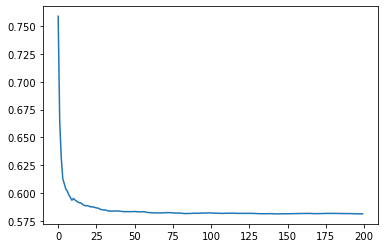

In [49]:
validate_rf_regressor(rfr,train_set, train_y, valid_set, valid_y)

In [51]:
# fi(rfr, train_set)

In [59]:
rfr = rfr = train_rf_regressor(train_set, train_y, n_estimators=200, min_samples_leaf=100, oob_score=False)

OOB score is not available

#######################################

RMSE - Valid: 0.5804044578378653
R2 - Valid : 0.32879872827614887

#######################################

RMSE - Train : 0.624019389213924
R2- Train : 0.4460638643794359

#######################################



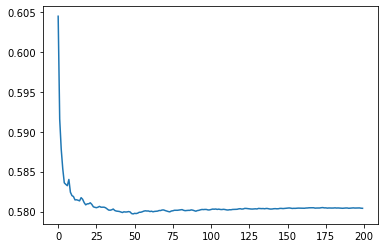

In [60]:
validate_rf_regressor(rfr,train_set, train_y, valid_set, valid_y)

In [61]:
rfr = rfr = train_rf_regressor(train_set, train_y, n_estimators=100, min_samples_leaf=25, oob_score=False)

OOB score is not available

#######################################

RMSE - Valid: 0.579228014347909
R2 - Valid : 0.3315169365540661

#######################################

RMSE - Train : 0.6126470253878965
R2- Train : 0.46607016730685846

#######################################



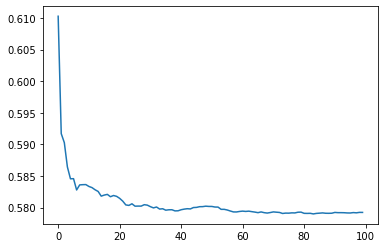

In [62]:
validate_rf_regressor(rfr,train_set, train_y, valid_set, valid_y)

In [63]:
rfr = rfr = train_rf_regressor(train_set, train_y, n_estimators=100, min_samples_leaf=15, oob_score=False)

OOB score is not available

#######################################

RMSE - Valid: 0.5786105050458364
R2 - Valid : 0.33294150325887995

#######################################

RMSE - Train : 0.6083897041244885
R2- Train : 0.4734650055861537

#######################################



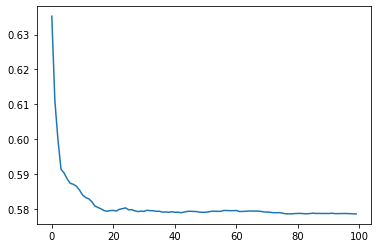

In [65]:
validate_rf_regressor(rfr,train_set, train_y, valid_set, valid_y)

In [91]:
rfr = rfr = train_rf_regressor(train_set, train_y, n_estimators=100, min_samples_leaf=15, oob_score=False)

OOB score is not available

#######################################

RMSE - Valid: 0.5824622223814959
R2 - Valid : 0.32403094069049576

#######################################

RMSE - Train : 0.6084859917623479
R2- Train : 0.4732983268193126

#######################################



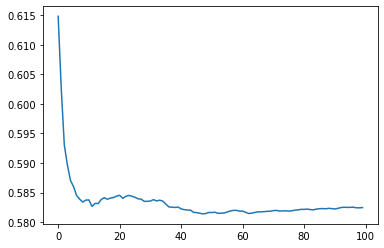

In [92]:
validate_rf_regressor(rfr,train_set, train_y, valid_set, valid_y)

## Train Model to make submission

In [67]:
test_idxs = np.where(sales.date_block_num == 34)[0]
train_idxs = np.where(sales.date_block_num<=33)[0]

In [68]:
test_set = sales.loc[test_idxs]
train_set = sales.loc[train_idxs]

In [69]:
train_set

,shop_id,item_id,date_block_num,month,year,item_cnt_month,item_category_id,months_since_sale,item_cnt_month - 1,item_cnt_month - 2,...,lag_avg_cat_subcode_date_block_num,lag_avg_shop_id_item_category_id_date,lag_avg_shop_id_cat_code_date,lag_avg_shop_id_cat_subcode_date,lag_avg_location_item_category_id_date,lag_avg_location_cat_code_date,lag_avg_location_cat_subcode_date,encoded_location,encoded_cat_code,encoded_cat_subcode
0,2.0,1.0,6.0,7.0,2013.0,0.0,76.0,6.0,0.0,0.0,...,0.008580,0.000000,0.030942,0.000000,0.000000,0.030942,0.000000,0.0,16.0,25.0
1,2.0,1.0,7.0,8.0,2013.0,0.0,76.0,7.0,0.0,0.0,...,0.008151,0.000000,0.021097,0.000000,0.000000,0.021097,0.000000,0.0,16.0,25.0
2,2.0,1.0,8.0,9.0,2013.0,0.0,76.0,8.0,0.0,0.0,...,0.009116,0.000000,0.025316,0.000000,0.000000,0.025316,0.000000,0.0,16.0,25.0
3,2.0,1.0,9.0,10.0,2013.0,0.0,76.0,9.0,0.0,0.0,...,0.010296,0.000000,0.026723,0.000000,0.000000,0.026723,0.000000,0.0,16.0,25.0
4,2.0,1.0,10.0,11.0,2013.0,0.0,76.0,10.0,0.0,0.0,...,0.009438,0.000000,0.025316,0.000000,0.000000,0.025316,0.000000,0.0,16.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15451542,59.0,22167.0,29.0,6.0,2015.0,0.0,49.0,11.0,0.0,0.0,...,0.089242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.0,4.0,34.0
15451543,59.0,22167.0,30.0,7.0,2015.0,0.0,49.0,12.0,0.0,0.0,...,0.117460,0.007407,0.005102,0.007407,0.007407,0.005102,0.007407,26.0,4.0,34.0
15451544,59.0,22167.0,31.0,8.0,2015.0,0.0,49.0,13.0,0.0,0.0,...,0.113404,0.029630,0.010204,0.029630,0.029630,0.010204,0.029630,26.0,4.0,34.0
15451545,59.0,22167.0,32.0,9.0,2015.0,0.0,49.0,14.0,0.0,0.0,...,0.100705,0.029630,0.017857,0.029630,0.029630,0.017857,0.029630,26.0,4.0,34.0


In [70]:
train_y = np.clip(train_set['item_cnt_month'],0,20)

In [71]:
train_set.drop(columns=['item_cnt_month'], inplace=True)
test_set.drop(columns=['item_cnt_month'], inplace=True)

In [72]:
rf_sub = train_rf_regressor(train_set, train_y, n_estimators=200, oob_score=False, min_samples_leaf=15)

In [73]:
fi(rf_sub, train_set)

,Features,Importance
0,item_cnt_month - 1,0.300894
1,avg_2_item_cnt_month,0.187347
2,avg_3_item_cnt_month,0.109062
3,avg_4_item_cnt_month,0.059977
4,lag_avg_item_id_date_block_num,0.042533
5,avg_5_item_cnt_month,0.029551
6,avg_6_item_cnt_month,0.027400
7,item_id,0.020439
8,lag_avg_shop_id_item_category_id_date,0.018688
9,month,0.017535


In [74]:
create_submission(test_set, test, rf_sub.predict(test_set))